# 2. Federated Averaging (FedAvg)

In [ ]:
import torch
from torch.utils.tensorboard import SummaryWriter

from data import artificial_1D_linear as data
from experiments.artificial_1D_linear.documentation import (
    evaluate,
    get_logging_dir,
    plot_data_split,
    plot_predictions,
)
from models.DenseNetwork import DenseNetwork
from utils.federated_learning import average_models

from experiments.artificial_1D_linear.smart_fed_avg_util import register_client_test_losses

### Hyperparemeters

In [6]:
BATCH_SIZE = 64

INPUT_FEATURES = 1
OUTPUT_FEATURES = 1
ARCHITECTURE = [12, 12, 12, 12]

LOSS_FN = torch.nn.MSELoss()

#### Parameters for the FedAvg

NUM_CLIENTS = 2
CLIENT_IDs = range(NUM_CLIENTS)
SPLIT_TYPE = "interval" # of the dataset
COMMUNICATION_ROUNDS = 10
CLIENT_EPOCHS = 100

### Model definitions

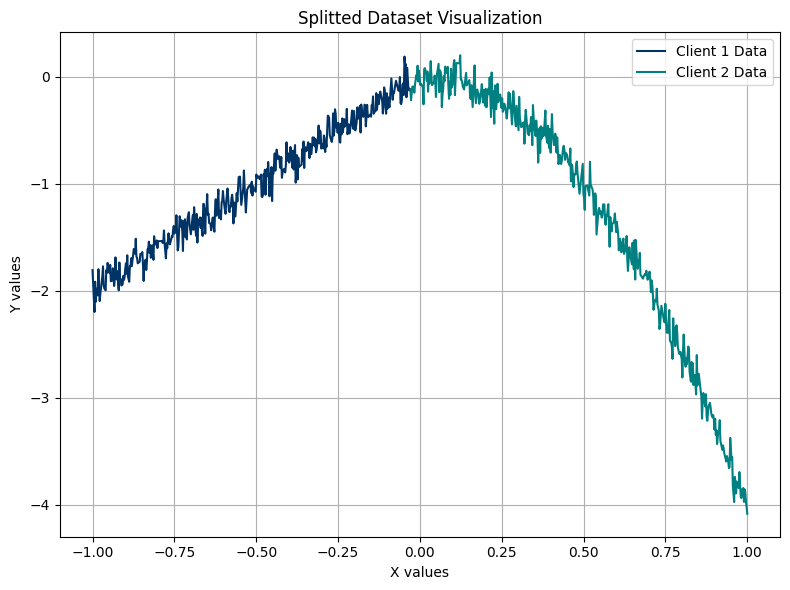

In [7]:
model_name = f"FedAvg_{NUM_CLIENTS}clients_{SPLIT_TYPE}-split"


writer = SummaryWriter(get_logging_dir(model_name))


client_train_dataloaders = data.get_client_test_dataloaders(
    NUM_CLIENTS, SPLIT_TYPE, BATCH_SIZE, shuffle=True
)

plot_data_split(client_train_dataloaders, writer)


clients = [
    DenseNetwork(DenseNetwork.Config(INPUT_FEATURES, ARCHITECTURE, OUTPUT_FEATURES))
    for _ in CLIENT_IDs
]

client_optimizers = [
    torch.optim.Adam(clients[client_no].parameters(), lr=0.001)
    for client_no in CLIENT_IDs
]

### Training

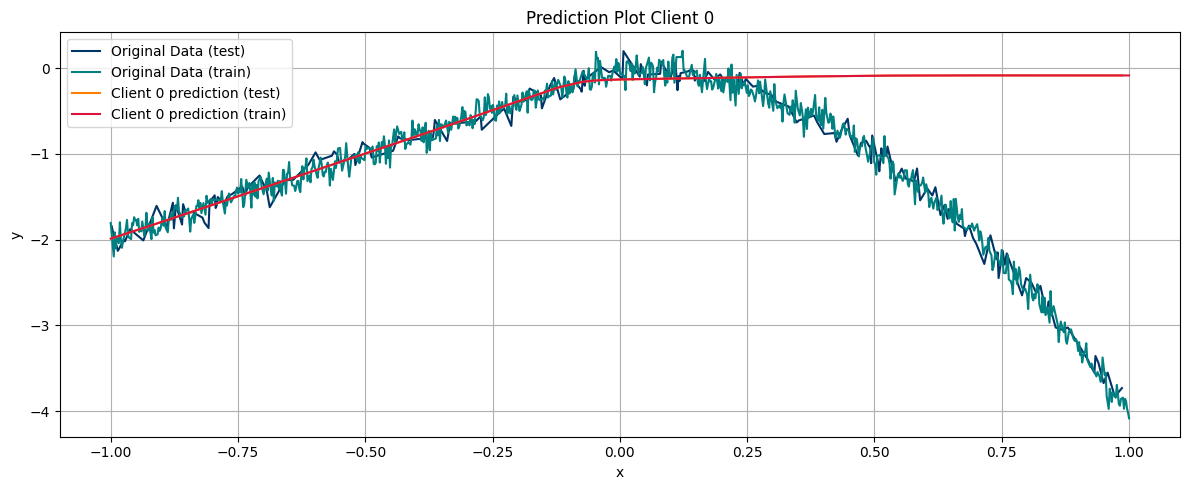

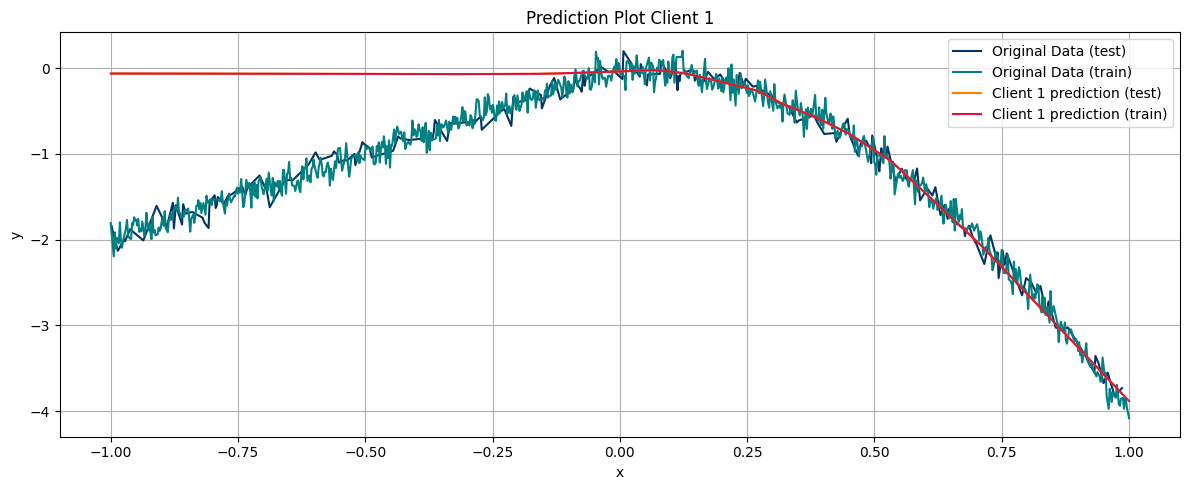

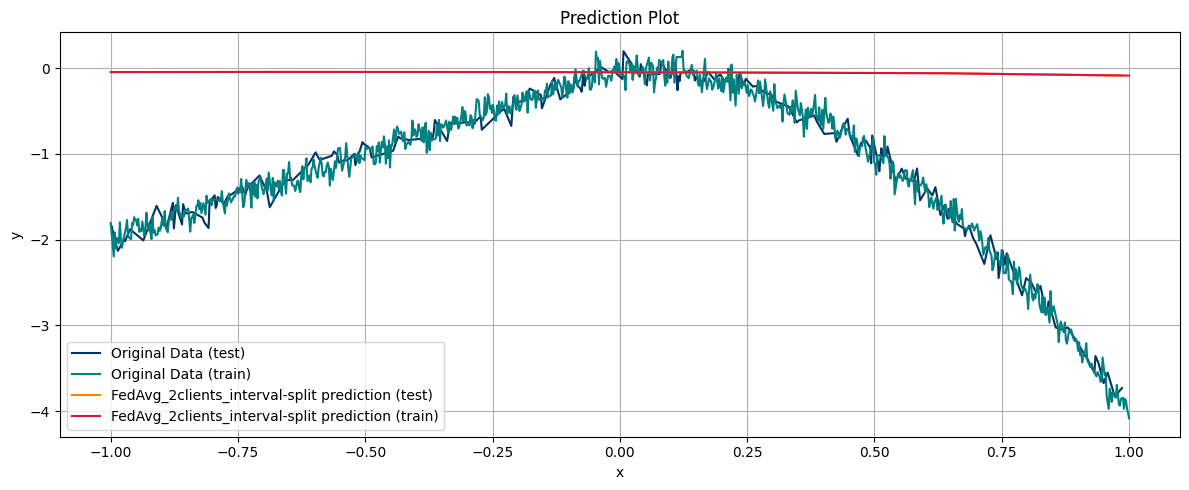

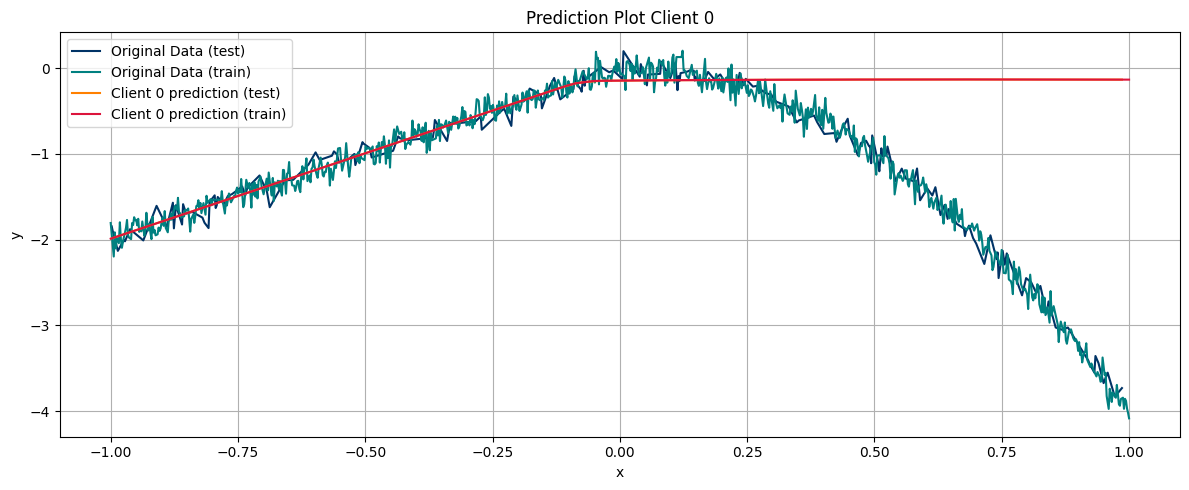

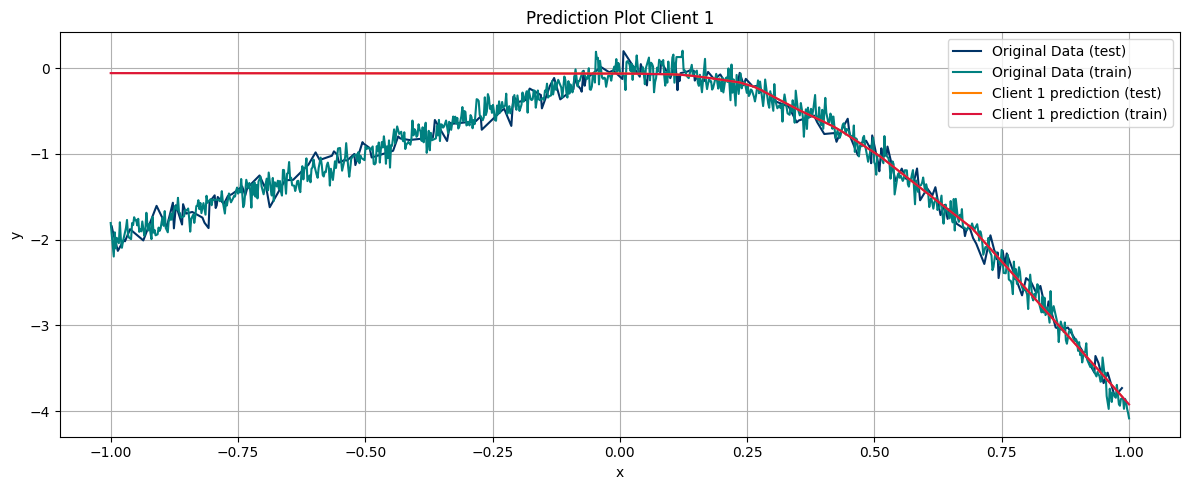

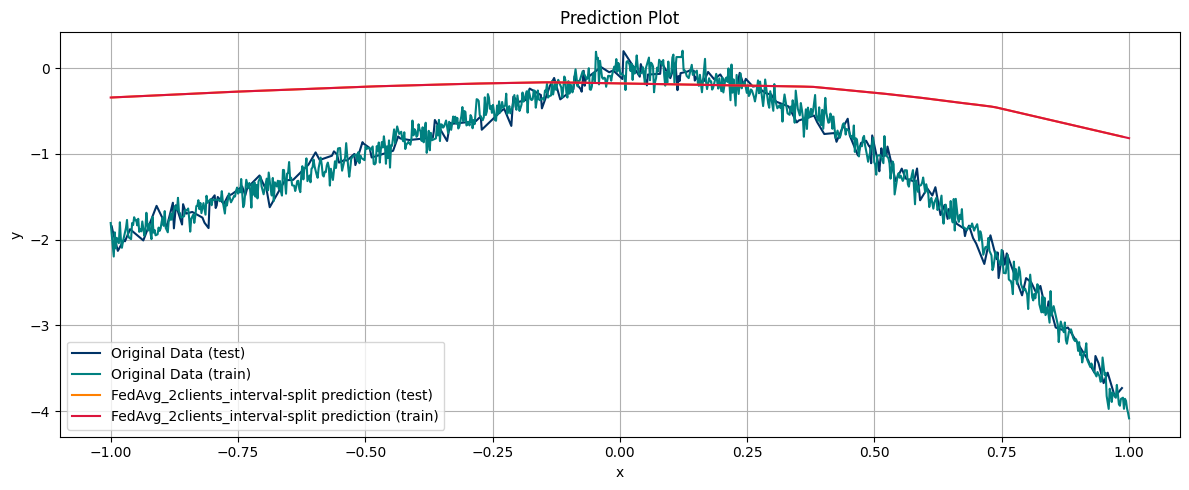

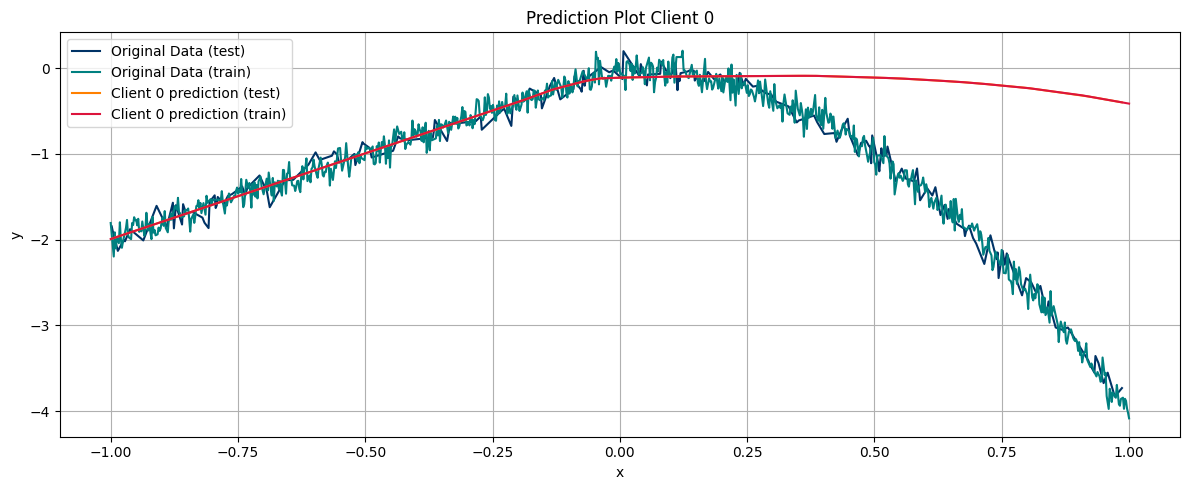

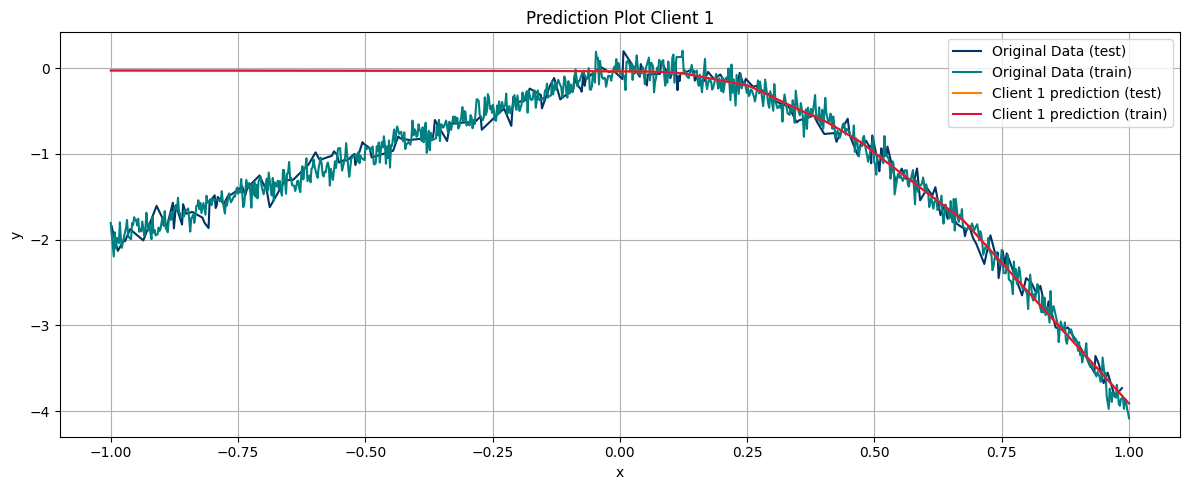

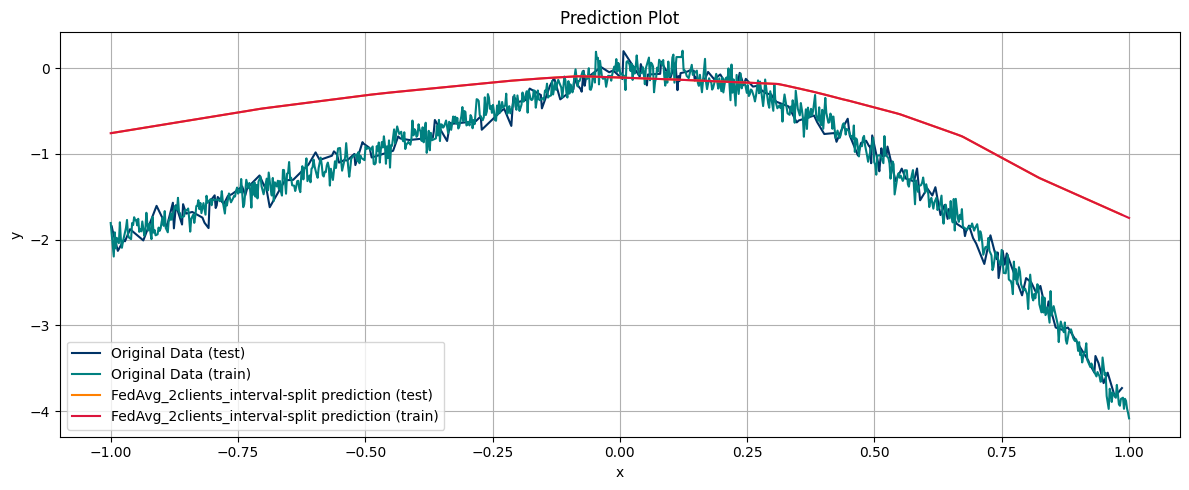

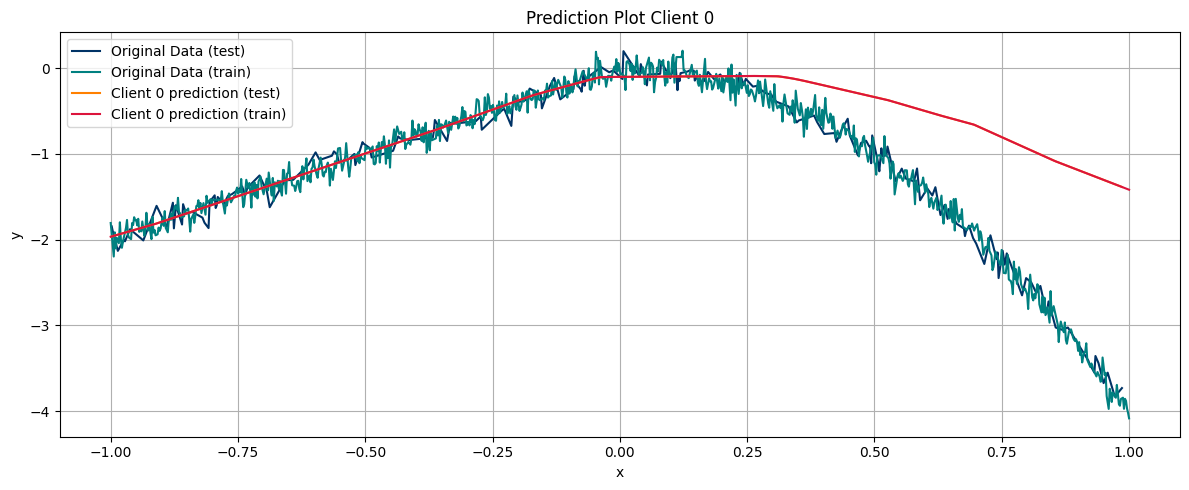

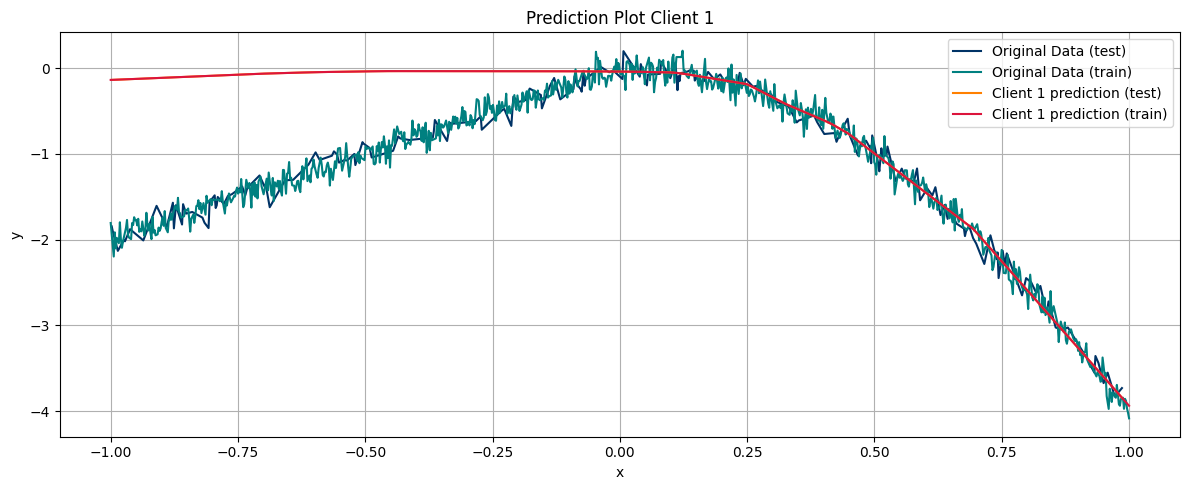

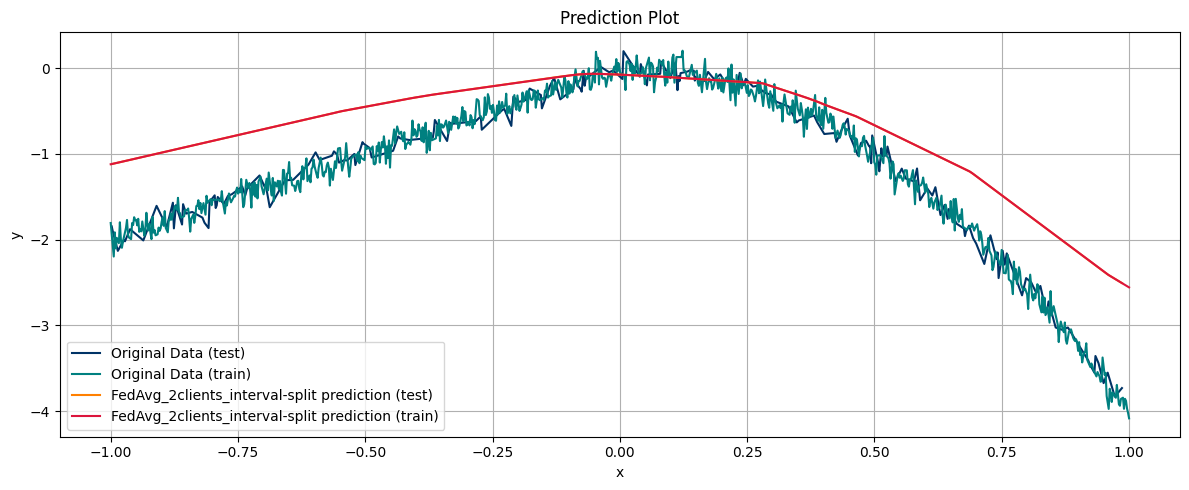

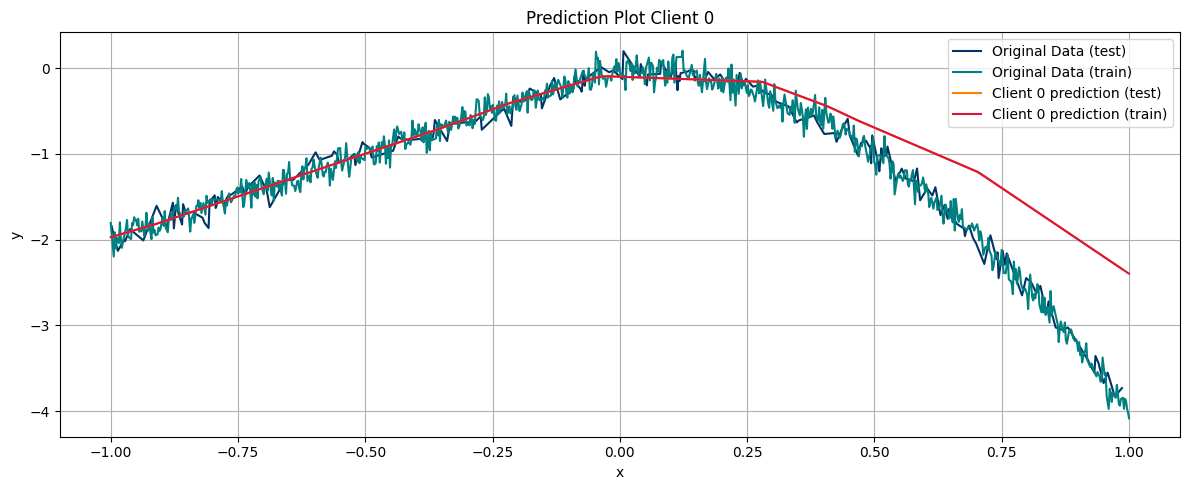

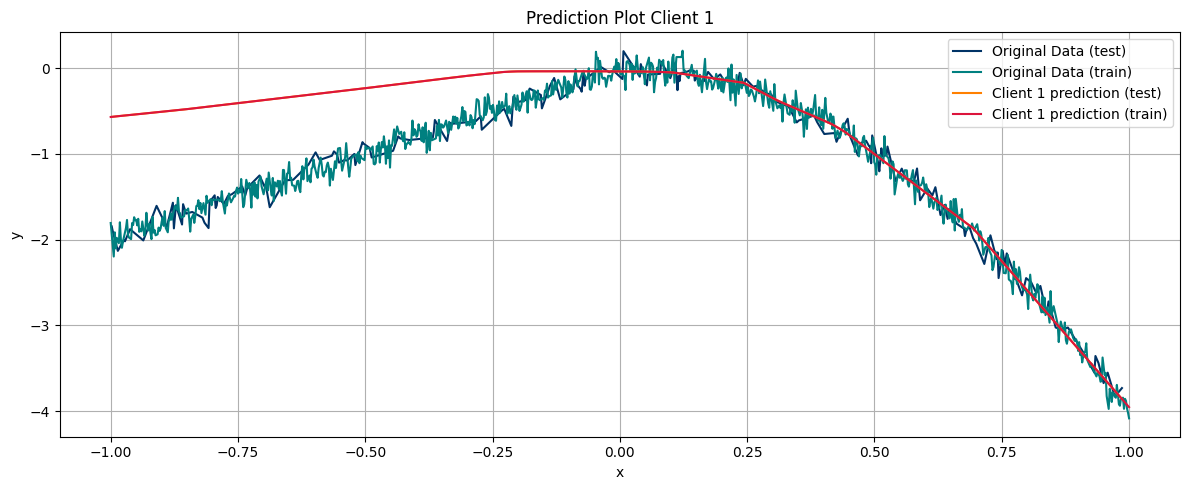

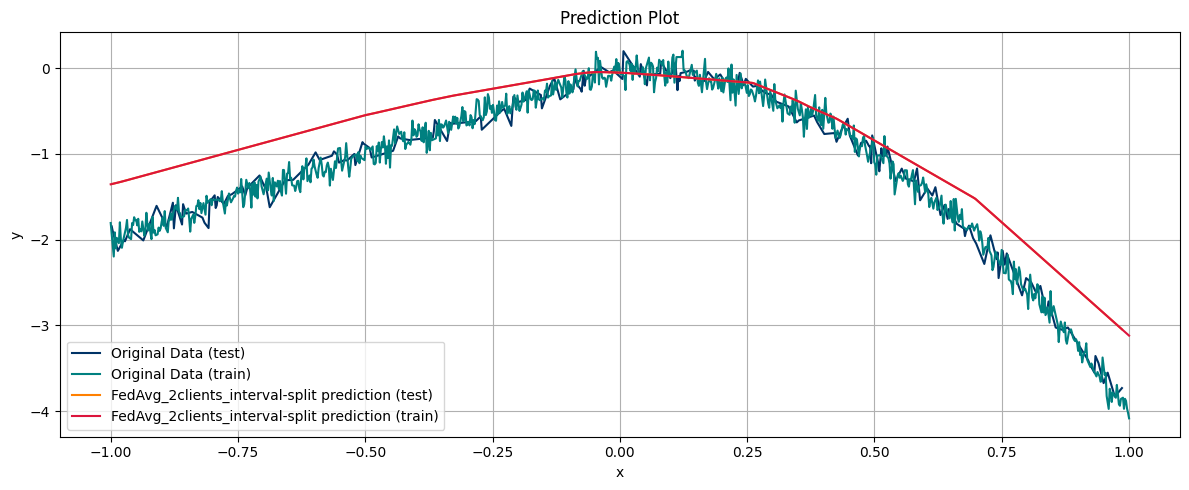

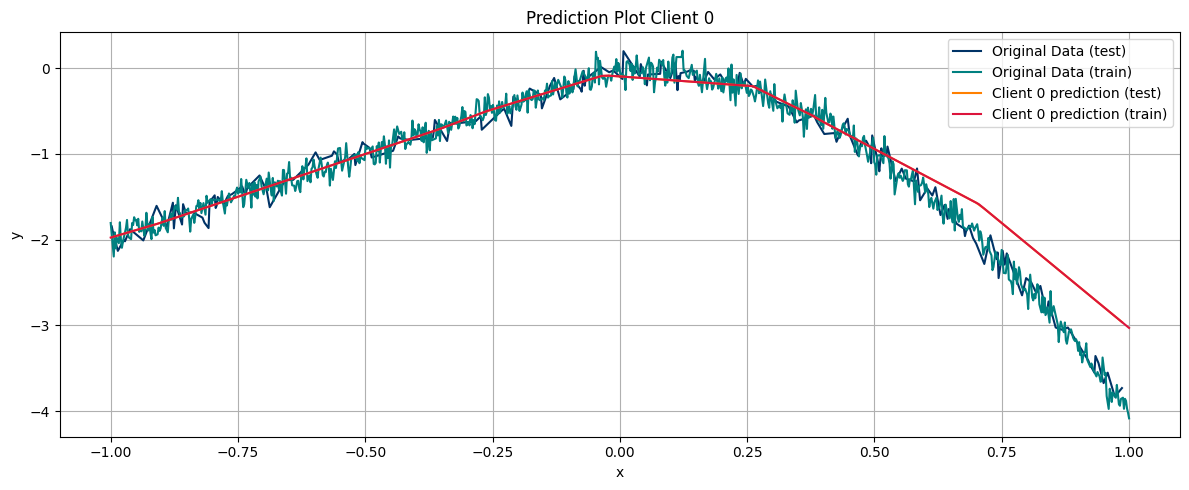

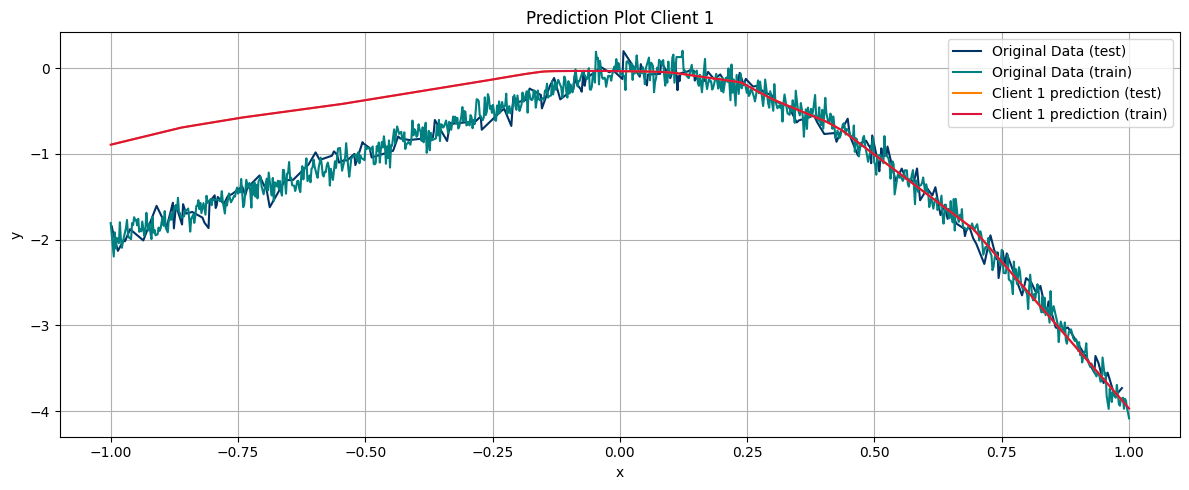

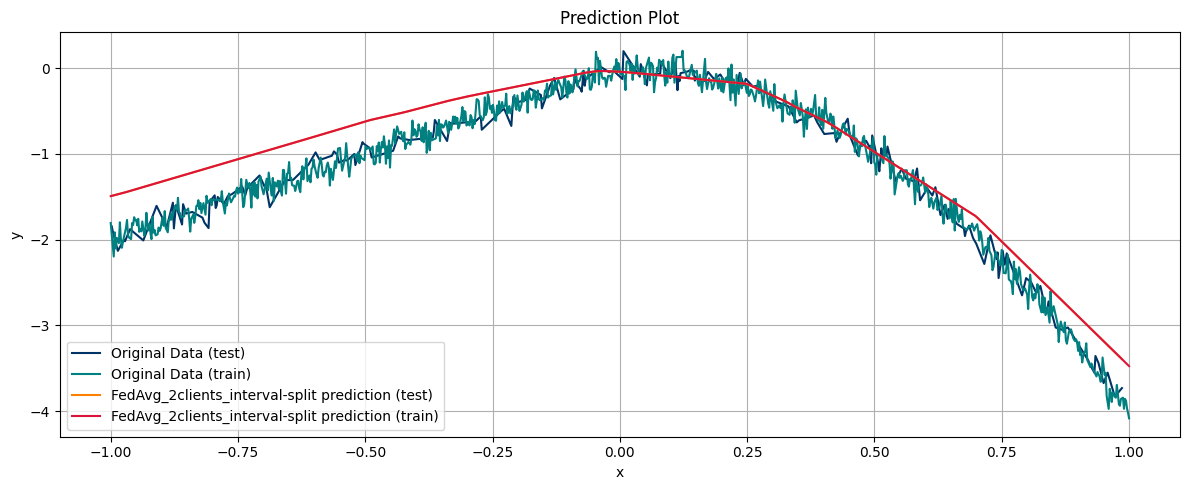

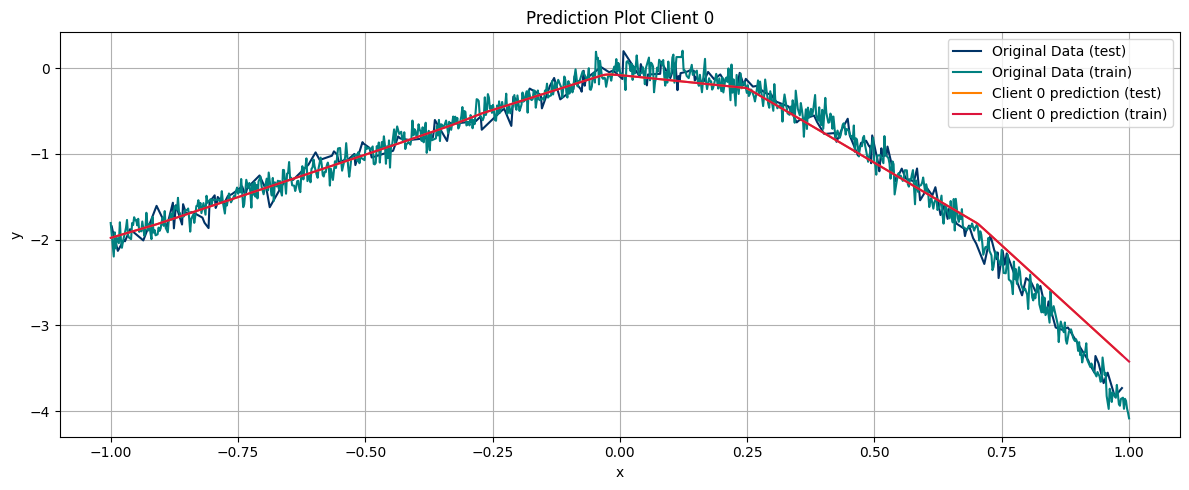

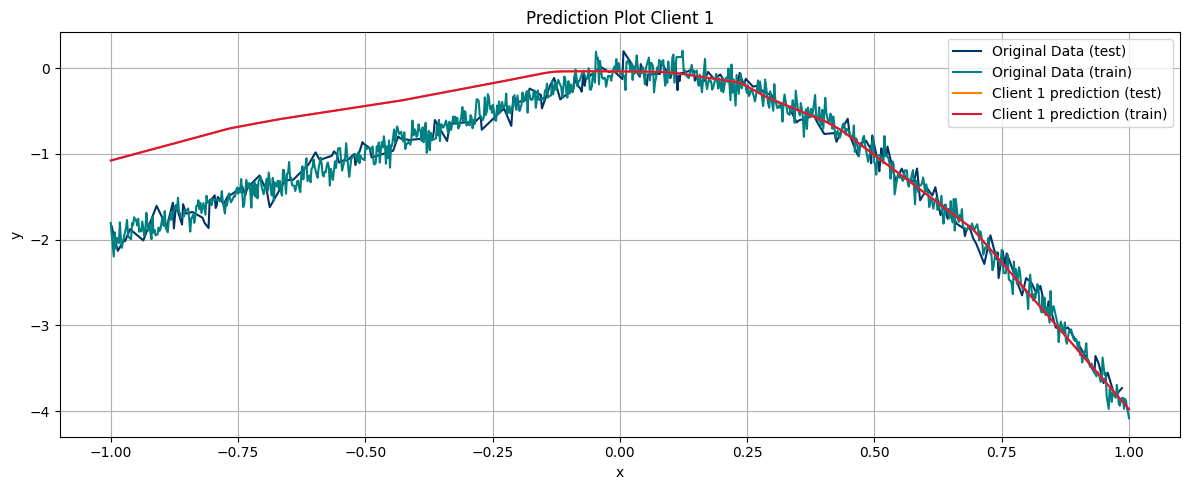

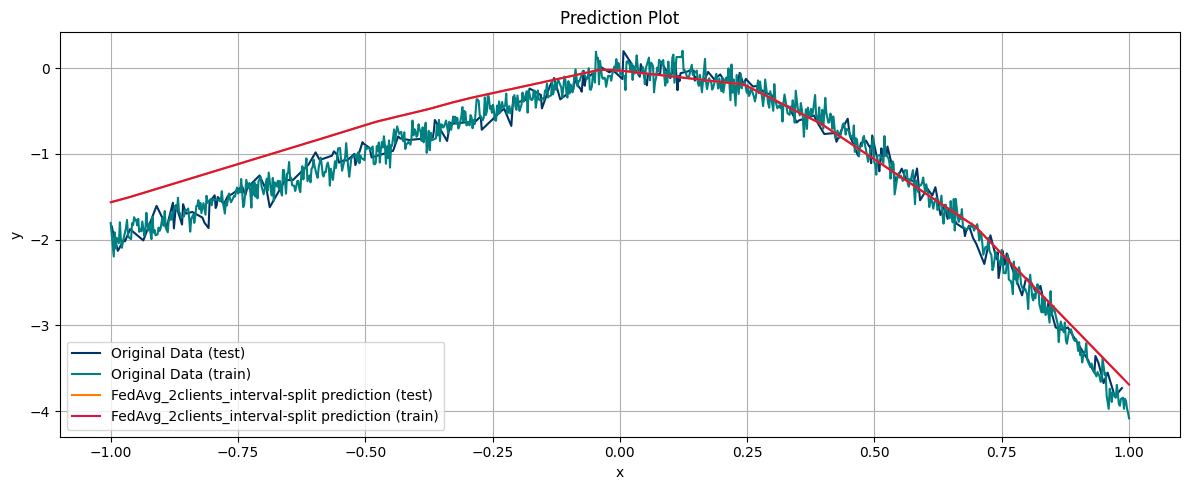

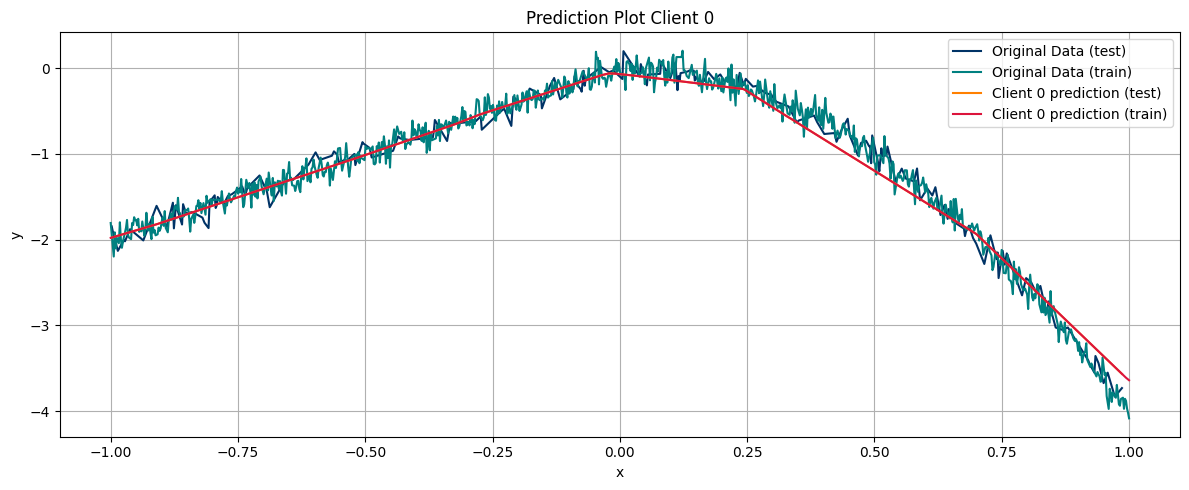

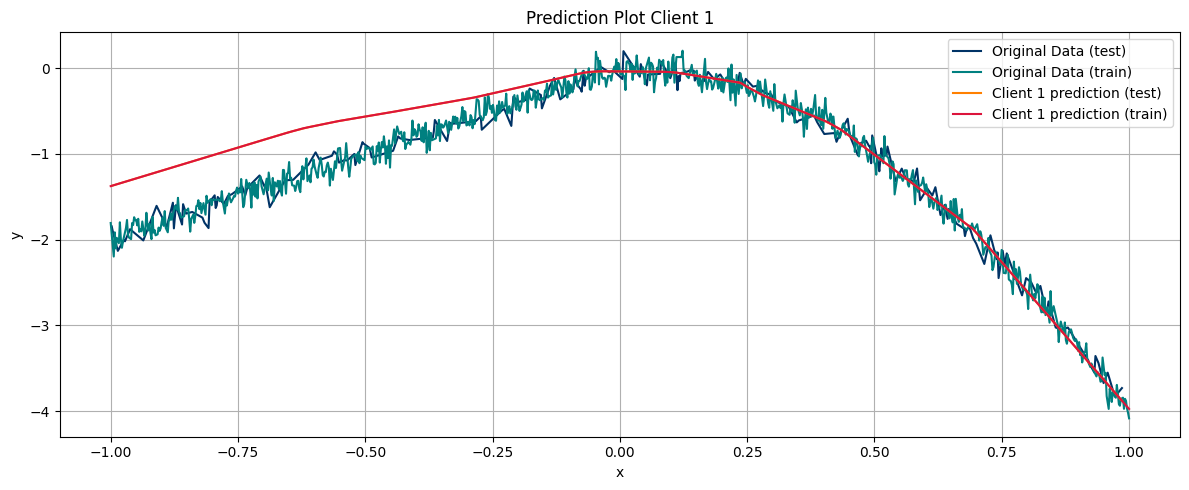

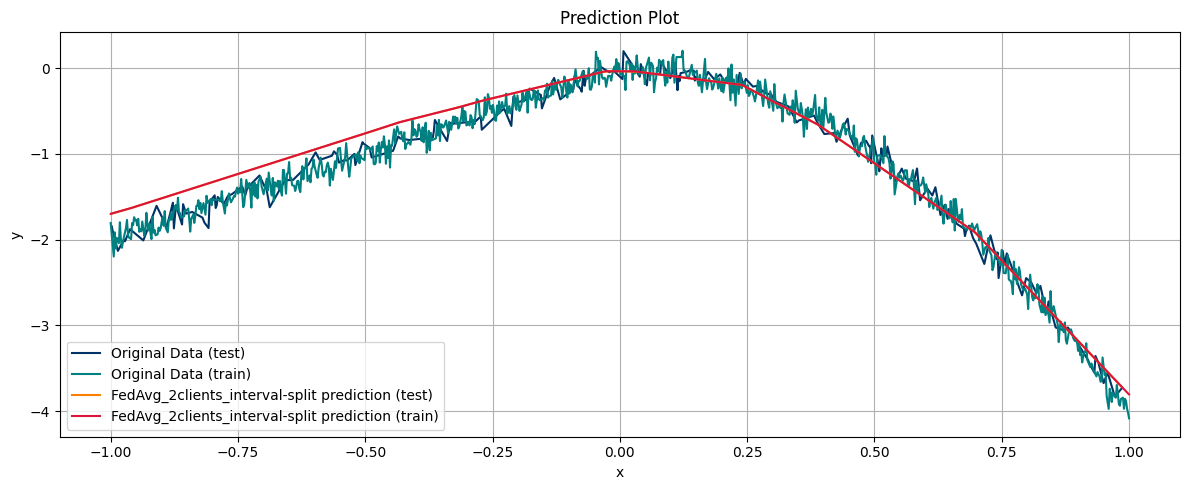

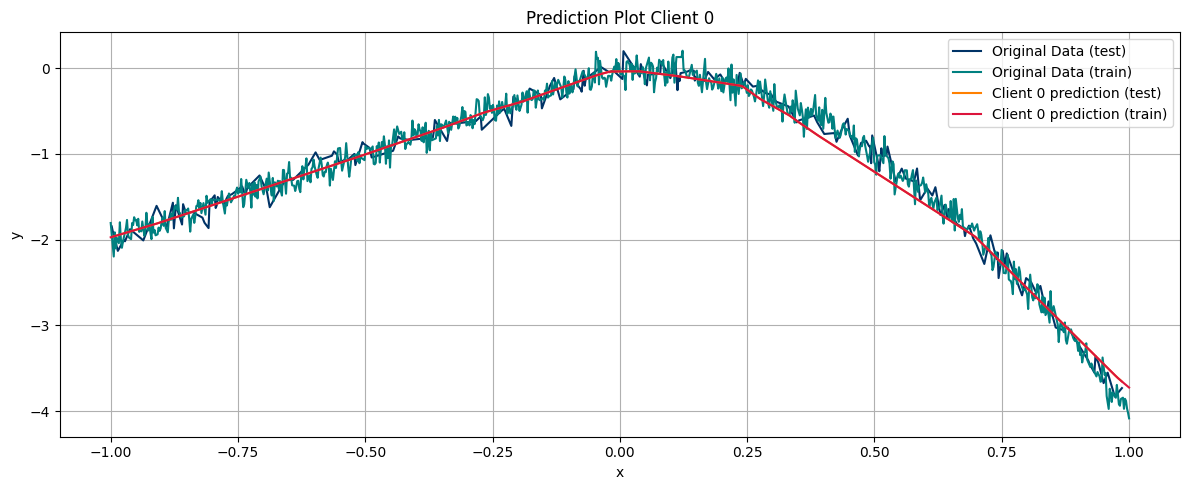

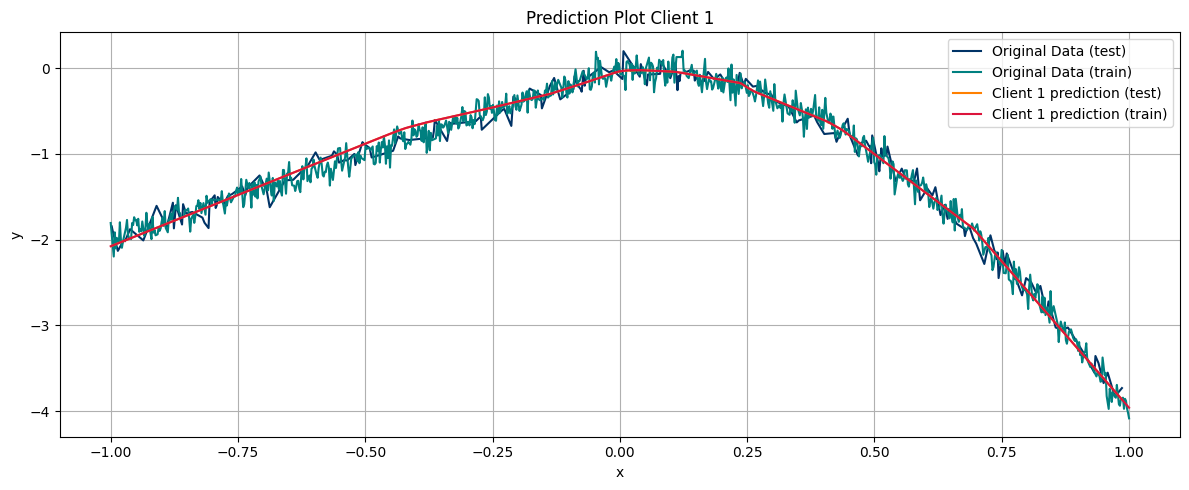

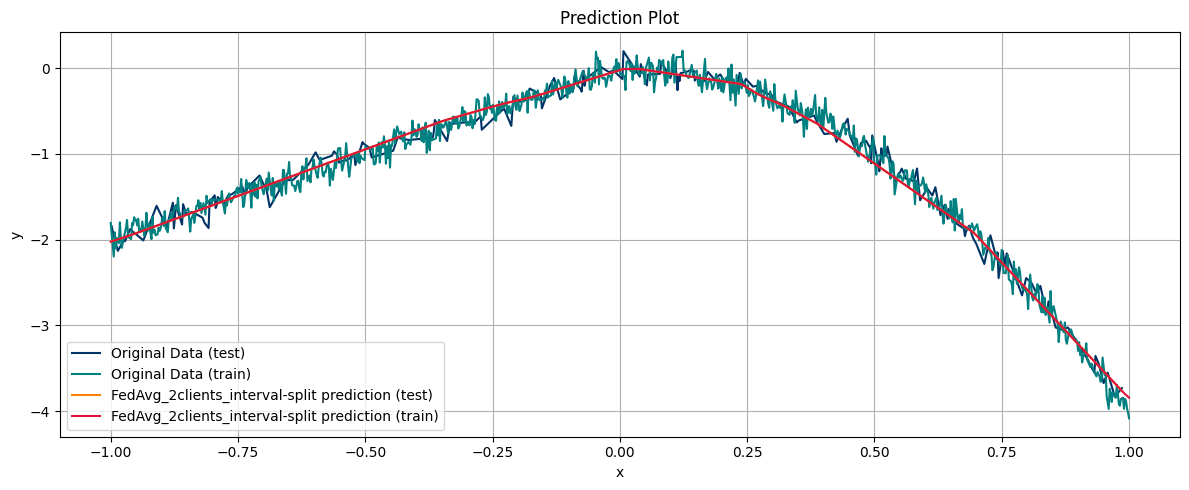

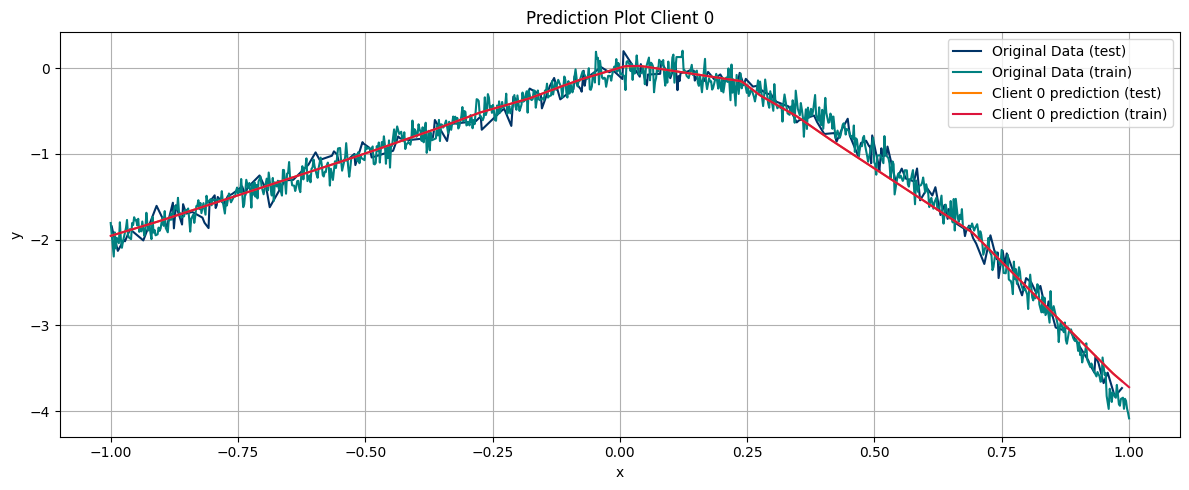

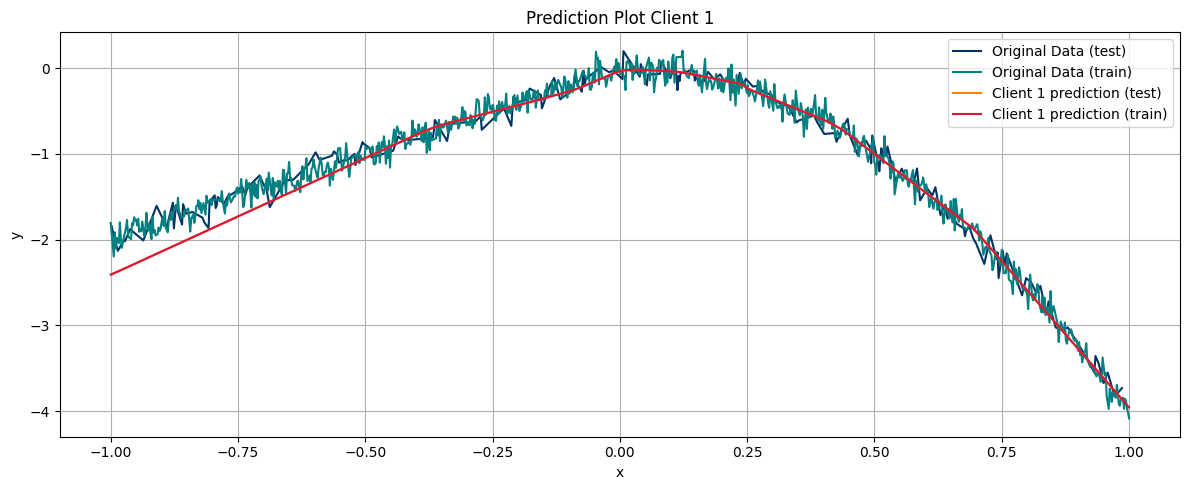

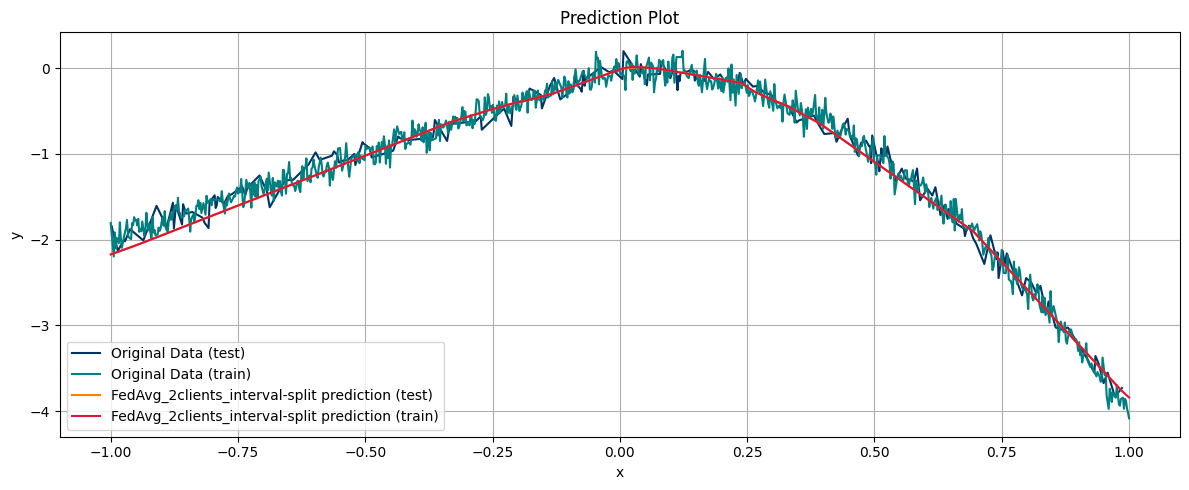

In [8]:
for cr in range(COMMUNICATION_ROUNDS):
    for client_no, client in zip(CLIENT_IDs, clients):
        client.train()

        for ce in range(CLIENT_EPOCHS):
            losses = []
            for x, y in client_train_dataloaders[client_no]:
                client_optimizers[client_no].zero_grad()
                y_hat = client(x)
                loss = LOSS_FN(y_hat, y)
                loss.backward()
                client_optimizers[client_no].step()
                losses.append(loss.item())

            writer.add_scalar(
                f"loss/client{client_no}",
                sum(losses) / len(losses),
                cr * CLIENT_EPOCHS + ce,
            )

    register_client_test_losses(
        clients=clients, client_ids=CLIENT_IDs, writer=writer, communication_round=cr
    )


    global_model = average_models(clients)
    writer.add_scalar("test_loss", evaluate(global_model), cr * CLIENT_EPOCHS)

    for client in clients:
        client.load_state_dict(global_model.state_dict())

    plot_predictions(global_model, model_name, writer, epoch=cr)
writer.add_hparams(
    {
        "client_epochs": CLIENT_EPOCHS,
        "num_clients": NUM_CLIENTS,
        "communication_rounds": COMMUNICATION_ROUNDS,
        "split_type": SPLIT_TYPE,
        "architecture": str(ARCHITECTURE)
    },
    {
        "MSE Test": evaluate(global_model),
    },
    run_name=".",
)
writer.close()